# Demo: Bifurcation of Steady States of the 1D KPP Equation

In [1]:
import numpy as np

import scipy.linalg # needed for matrix exponential

import matplotlib.pyplot as plt
import cmocean
import cmocean.cm as cmo

import time

# this makes sure the images don't come out looking muddy on 
# retina displays (which your computer probably uses)
%config InlineBackend.figure_format='retina'

In this demo, ... 

## Suggested References

- Grindrod

- Logan

- Math bio books? 

- Combustion theory books?

## Background Theory

TODO: Fill this in with some scientific background, and discuss the numerical method in context. 

\begin{equation}
\left\{
\begin{aligned}
u_{xx} &= -u(1-u) \quad \forall \ x \in (0,L),
\\ \\ 
u(0) &= u(L) = 0. 
\end{aligned}
\right.
\end{equation}

To directly use our Chebyshev differentiation codes, we transform the coordinates according to 
$$
x\mapsto y(x) = \frac{2}{L}x - 1.
$$
This means the domain $x\in [0,L]$ becomes $y\in [-1,1]$. 

## Numerical Examples 

We start by assembling all the Chebyshev differentiation stuff we'll need.   

In [2]:
def chebnodes(N):
# spits out an array of the n^th Chebyshev nodes in [-1,1]. NOTE: the output is arranged so 
# x[-1] = -1, x[0]=1. In other words, the grid is presented right-to-left instead.
# This is consistent with the convention in Trefethen's book

    theta = (np.pi/(N))*np.arange(0,N+1, dtype=int)
    
    x = np.cos(theta)
    
    return x

def chebdiff(N):
# spits out N+1 x N+1 Chebyshev differentiation matrix 

    c = np.ones([N+1,1])
    
    c[0] = 2.
    
    c[-1] = 2. 
    
    c = (c*(-1)**np.arange(0,N+1)).T
    
    x = chebnodes(N)
        
    X = np.tile(x,[N+1,1])
    
    dX = X - X.T
        
    D = c*(1./c.T)/(dX + np.identity(N+1))
        
    D -= np.diag(np.sum(D.T, axis=1))
    
    return D.T

Now, we set up the fixed point iteration to find the steady-state. This is an $N\times N$ system of nonlinear algebraic equations: since $u(x)$ satisfies homogeneous Dirichlet BCs, we need only track the interior values. 

In [3]:
def f(u):
    return -u*(1.-u)

def solve_transformed_bvp(L, N, u_guess):

    # First, obtain the Chebyshev differentiation matrix
    D = chebdiff(N)
    D2 = np.linalg.matrix_power(D,2)[1:N, 1:N] # square D, then kill the non-contributing bdry pieces.

    # Now, set up a fixed-point iteration
    
    # create stopping flag (True if not slowed down, False when slowed down)
    speed_flag = True 

    # make initial guess
    u = u_guess[1:N] # initial guess of equilibrium point on transformed grid [-1,1]

    # make sure initial guess is actually positive and lies below the carrying capacity 
    u = np.abs(u)

    u[u>=1] = 1. 

    # initialize counter
    cnt = 0 

    while speed_flag == True: 
    
        RHS = f(u)*(L/2.)**2

        u_new = np.linalg.solve(D2, RHS) # get a new guess at fixed point iterating the map
    
        speed = np.linalg.norm(u_new- u, ord=np.inf) # check speed of convergence
    
        if speed < 1e-10: # set tolerance to whatever you want
        
            speed_flag = False # stop if slowdown is too much
    
        cnt += 1
        
        u = u_new # update guess

    # now tack on the BCs
    uu = np.zeros(N+1, dtype=float)

    uu[1:N] = u
    
    # equilibirum solution is now stored as uu!
    
    print('Number of iterations required to converge =', cnt)
    
    return uu


For our first test, we simply solve the problem for a fixed value of $L$ with a suitable
(normal) random initial guess. We then plot the solution and see directly how it compares to the perturbative approximation.

In [4]:
N = 80
L = np.pi*1.01

# Cheb nodes on transformed grid
x = chebnodes(N)

# Chebyshev nodes on actual grid
xx = (L/2.)*(x + 1.) 

if L>= np.pi:

    uu_pert = 0.75*(L-np.pi)*np.sin(np.pi*xx/L)
    
    u_guess = uu_pert
    
else:

    u_guess = np.random.randn(N)

uu = solve_transformed_bvp(L, N, u_guess) 

Number of iterations required to converge = 550


Discrepancy between numerical and perturbative approximations = 0.0018


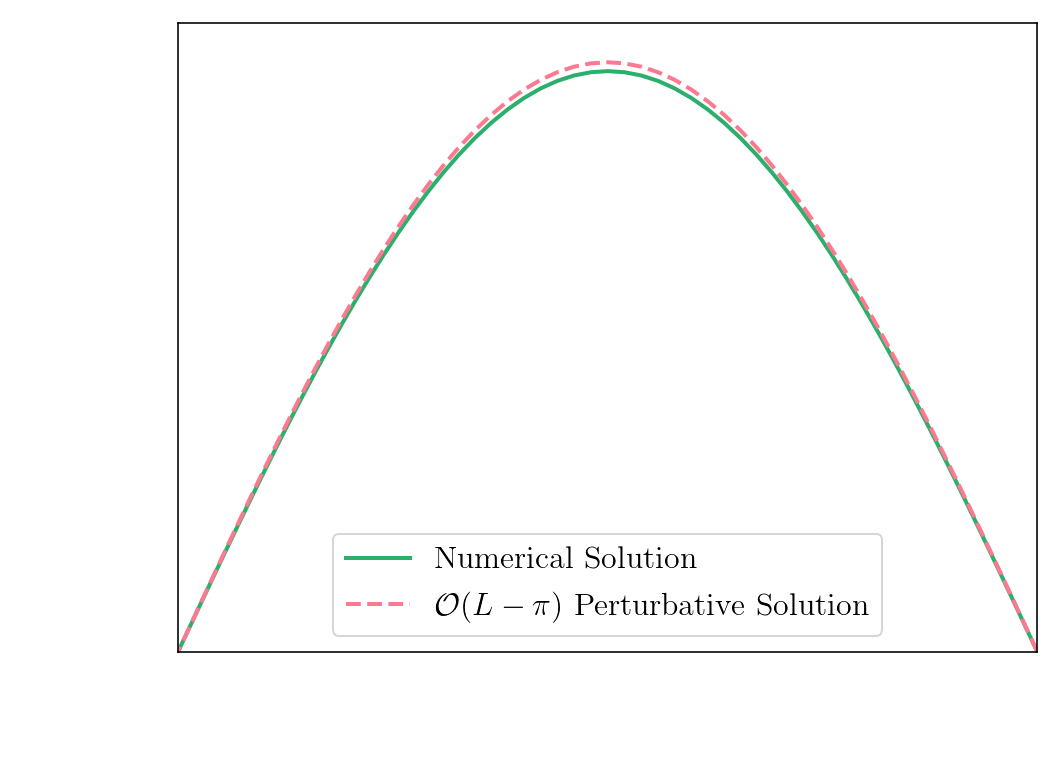

In [5]:
fig, ax =plt.subplots()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# threshold within our tolerance
uu[np.abs(uu)<1e-9] = 0.
    
plt.plot(xx, uu, color='xkcd:jade green', linewidth='2', linestyle='solid', label='Numerical Solution')

if L>= np.pi:
        
    plt.plot(xx, uu_pert, color='xkcd:carnation', linewidth='2', linestyle='dashed', label='$\mathcal{O}(L-\pi)$ Perturbative Solution')    
    
    print('Discrepancy between numerical and perturbative approximations = %.4f' % np.linalg.norm(uu-uu_pert))
    
else: 
    
    pass

ax.legend(fontsize=16)

plt.xlim([0,L])
ymax = np.amax([0.8*(L-np.pi), 0.01])
plt.ylim([-1e-5*ymax, ymax])

plt.xlabel(r"$x$", fontsize=26, color = 'w')
plt.ylabel(r"$u(x)$", fontsize=26, color='w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=16, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=16, rotation=0, color = 'w')
ax.locator_params(axis='y', nbins=6)
ax.locator_params(axis='x', nbins=4)

plt.tight_layout()

fig.set_size_inches(8, 6)
    
plt.show()

Now, for $L\geq \pi$ we examine how the error between numerical and perturbative solutions as a function of $\epsilon \doteq L-\pi$. 

In [19]:
N = 80 

x = chebnodes(N)

M = 7

epsilons = np.logspace(-6,0, num = M)

Ls = np.pi + epsilons

error= np.zeros(M, dtype=float)

for m in np.arange(0,M): 
    
    L = Ls[m]

    # Chebyshev nodes on actual grid
    xx = (L/2.)*(x + 1.) 
    
    u_pert = 0.75*(L-np.pi)*np.sin(np.pi*xx/L)
    
    u_guess = u_pert
    
    u_num = solve_transformed_bvp(L, N, u_guess)
    
    error[m] = np.linalg.norm(u_num-u_pert, ord=np.inf)

Number of iterations required to converge = 1
Number of iterations required to converge = 1
Number of iterations required to converge = 2
Number of iterations required to converge = 1274
Number of iterations required to converge = 1207
Number of iterations required to converge = 219
Number of iterations required to converge = 18


Let's define the discrepancy between the numerical solution $u_{\text{num}}$ and the $\mathcal{O}\left(\epsilon\right)$ perturbative solution $u_{\text{pert}}$ by 
$$
E(\epsilon) = \left\|u_{\mathrm{num}}-u_{\mathrm{pert}}\right\|_{L^{\infty}\left([0,\pi+\epsilon]\right)}
$$

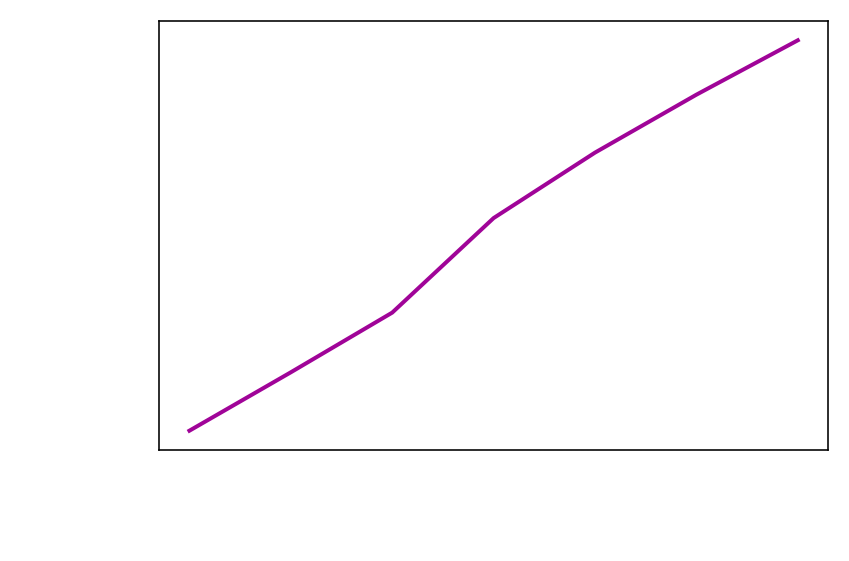

Least-Squares Slope of Error Curve = 2.31


In [20]:
plt.loglog(epsilons, error, color = 'xkcd:barney purple', linestyle='solid', linewidth='2')

plt.xlabel(r"$\epsilon$", fontsize=26, color = 'w')
plt.ylabel(r"$E(\epsilon)$", fontsize=26, color='w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=16, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=16, rotation=0, color = 'w')
ax.locator_params(axis='y', nbins=6)
ax.locator_params(axis='x', nbins=4)

plt.tight_layout()

fig.set_size_inches(8, 6)
    
plt.show()
    
slope = np.polyfit(np.log(epsilons), np.log(error), 1)[0]
print('Least-Squares Slope of Error Curve = %.2f' % slope)

Our experiments indicate that the error in the $\mathcal{O}\left(\epsilon\right)$ approximation of $u$ is roughly $\mathcal{O}\left(\epsilon^{2.3}\right)$. This is very close to the predicted error of $\mathcal{O}\left(\epsilon^2\right)$ arising from perturbation theory. 